In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-prices-poland/Car_Prices_Poland_Kaggle.csv


In [2]:
#Creating Data Frame from my csv file
df=pd.read_csv('/kaggle/input/car-prices-poland/Car_Prices_Poland_Kaggle.csv')
print(df)

        Unnamed: 0   mark  model    generation_name  year  mileage  \
0                0   opel  combo         gen-d-2011  2015   139568   
1                1   opel  combo         gen-d-2011  2018    31991   
2                2   opel  combo         gen-d-2011  2015   278437   
3                3   opel  combo         gen-d-2011  2016    47600   
4                4   opel  combo         gen-d-2011  2014   103000   
...            ...    ...    ...                ...   ...      ...   
117922      117922  volvo  xc-90  gen-ii-2014-xc-90  2020    40000   
117923      117923  volvo  xc-90  gen-ii-2014-xc-90  2017    51000   
117924      117924  volvo  xc-90  gen-ii-2014-xc-90  2016    83500   
117925      117925  volvo  xc-90  gen-ii-2014-xc-90  2017   174000   
117926      117926  volvo  xc-90  gen-ii-2014-xc-90  2016   189020   

        vol_engine      fuel              city       province   price  
0             1248    Diesel             Janki    Mazowieckie   35900  
1             1

In [3]:
print(df.describe(percentiles=[.8,.2,.5,0.9,0.1]).round()) #The pareto principle is our everything

       Unnamed: 0      year    mileage  vol_engine      price
count    117927.0  117927.0   117927.0    117927.0   117927.0
mean      58963.0    2013.0   140977.0      1812.0    70300.0
std       34043.0       6.0    92369.0       644.0    84825.0
min           0.0    1945.0        0.0         0.0      500.0
10%       11793.0    2006.0     5000.0      1199.0    12900.0
20%       23585.0    2008.0    47340.0      1390.0    18500.0
50%       58963.0    2013.0   146269.0      1796.0    41900.0
80%       94341.0    2018.0   218544.0      1997.0    98900.0
90%      106133.0    2021.0   255000.0      2435.0   161400.0
max      117926.0    2022.0  2800000.0      7600.0  2399900.0


We can see that 90% cars have price below ~160k PLN and 90% above ~13k PLN

Also 80% are newer than 2008 year 

And just 10% have milage more than 255.000 KM

So for my model I will use this confine. It willhelps minmax normalazing

In [4]:
#Simple filtr
df=df[df['year']>=2008]
df=df[df['price']>=13000]
df=df[df['price']<=160000]
df=df[df['mileage']<=255000]
print(df)


        Unnamed: 0   mark  model    generation_name  year  mileage  \
0                0   opel  combo         gen-d-2011  2015   139568   
1                1   opel  combo         gen-d-2011  2018    31991   
3                3   opel  combo         gen-d-2011  2016    47600   
4                4   opel  combo         gen-d-2011  2014   103000   
5                5   opel  combo         gen-d-2011  2017   121203   
...            ...    ...    ...                ...   ...      ...   
117915      117915  volvo  xc-90  gen-ii-2014-xc-90  2017    72000   
117920      117920  volvo  xc-90  gen-ii-2014-xc-90  2018    53500   
117924      117924  volvo  xc-90  gen-ii-2014-xc-90  2016    83500   
117925      117925  volvo  xc-90  gen-ii-2014-xc-90  2017   174000   
117926      117926  volvo  xc-90  gen-ii-2014-xc-90  2016   189020   

        vol_engine      fuel             city            province   price  
0             1248    Diesel            Janki         Mazowieckie   35900  
1      

In [5]:
print(df['city'].value_counts())
print(df['city'].value_counts().describe(percentiles=[0.2,.5,.8]))

Warszawa       5705
Łódź           2177
Kraków         1850
Wrocław        1625
Katowice       1619
               ... 
Knyszyn           1
Paprotno          1
Niepruszewo       1
Baranówka         1
Bledzew           1
Name: city, Length: 3323, dtype: int64
count    3323.000000
mean       23.085766
std       140.780606
min         1.000000
20%         1.000000
50%         2.000000
80%        12.000000
max      5705.000000
Name: city, dtype: float64


Here we can see that 80% cities has less than 12 listings.here is 3323 So I'd like to use about 10% cites it is first 300.

We will have city if it is in top of Poland cities or We will have only one province as location factor

In [6]:
#Finding top locations
top_cities=df['city'].value_counts()[:300].index.tolist()
print(top_cities[:20])

['Warszawa', 'Łódź', 'Kraków', 'Wrocław', 'Katowice', 'Poznań', 'Gdańsk', 'Lublin', 'Piaseczno', 'Radom', 'Szczecin', 'Białystok', 'Płock', 'Bydgoszcz', 'Częstochowa', 'Zabrze', 'Chorzów', 'Rzeszów', 'Gniezno', 'Bielany Wrocławskie']


In [7]:
#Now we needto create new column with new location
df['location']=[list(i)[0] if list(i)[0] in top_cities else list(i)[1] for i in df[['city','province']].values]
print(df['location'].value_counts()[-20:])

Malbork                     41
Kraczkowa                   41
Dojazdów                    41
Człuchów                    41
Kwidzyn                     41
Maków Mazowiecki            41
Brodnica                    40
Sopot                       40
Świecie                     40
Sade Budy                   40
Nowe Miasto nad Pilicą      40
Jasień                      40
Pawłowice                   39
Grójec                      39
Moravian-Silesian Region    35
Berlin                       3
Wiedeń                       2
Niedersachsen                1
(                            1
Nordrhein-Westfalen          1
Name: location, dtype: int64


So it works! But some not-polish places here. Remove it!

In [8]:
#Removing wrong places
dropping=df['location'].value_counts().index[-5:].tolist()
for i in dropping:
    df=df[df['location']!=i]

So I will not use vol_engine as numeric data because we have hybrids and electric cars and theay have other rules, also demand is determined by people and people see vol_engine like 1.2, 1.9, 3.0 not like 1221cm3 1897cm3 or 2980cm3. So I round this data 

In [9]:
#Round vol_engine
df['vol_engine']=df['vol_engine'].round(-2)
print(df)

        Unnamed: 0   mark  model    generation_name  year  mileage  \
0                0   opel  combo         gen-d-2011  2015   139568   
1                1   opel  combo         gen-d-2011  2018    31991   
3                3   opel  combo         gen-d-2011  2016    47600   
4                4   opel  combo         gen-d-2011  2014   103000   
5                5   opel  combo         gen-d-2011  2017   121203   
...            ...    ...    ...                ...   ...      ...   
117915      117915  volvo  xc-90  gen-ii-2014-xc-90  2017    72000   
117920      117920  volvo  xc-90  gen-ii-2014-xc-90  2018    53500   
117924      117924  volvo  xc-90  gen-ii-2014-xc-90  2016    83500   
117925      117925  volvo  xc-90  gen-ii-2014-xc-90  2017   174000   
117926      117926  volvo  xc-90  gen-ii-2014-xc-90  2016   189020   

        vol_engine      fuel             city            province   price  \
0             1200    Diesel            Janki         Mazowieckie   35900   
1    

I know that some models don't have generations but it is important option because same models can have few generations at same time. And this difference can determine the price. So I combine this data

In [10]:
#Replacing n/a data
df['generation_name'].fillna('No_gen',inplace=True)
#Create new name
df['name']=df['mark']+" "+df['model']+" "+df['generation_name']
print(len(df['name'].unique()))

487


Now I'd like to add column NEW. if car has 2021-2022 year and millage below 1.000 km it will be mark as new 


In [11]:
#Creating "new" column
df['new']=[1 if i[0]<999 and i[1]>2020 else 0 for i in df[['mileage','year']].values.tolist()]
print(df['new'].value_counts())

#Save DF for 
df.to_csv('ready_df')

0    71200
1     5506
Name: new, dtype: int64


In [12]:
#Some my functions for normalization 

#Create dict={item:noraml_item}
def get_dict_items(items):
    dict_model_arr={}
    items=list(set(items))
    number_items=len(items)
    for i in items:
        base_arr = [(lambda x: 0)(x) for x in range(number_items)]
        model_arr=base_arr
        model_arr[items.index(i)]=1
        dict_model_arr.update({i:model_arr})    
    return dict_model_arr

#List of normal items from dcit
def get_norm_items(dict_items,items):
    norm_items=[]
    for i in items:
        norm_items.append(dict_items[i])
    return norm_items

#Numbers normalization
def get_norm_numbers(numbers):
    min_n=min(numbers)
    max_n=max(numbers)
    range_=max_n-min_n
    norm_numbers=[]
    for n in numbers:
        norm_n=(n-min_n)/range_
        norm_numbers.append([norm_n])
    return norm_numbers

#Some lists to one
def tog_lists(lists):
    data=[]
    for l in lists:
        data+=l
    return np.array(data)


In [13]:
#Creating input, output and test data for model

#Shuffle data
df=df.sample(frac=1)
# df=df[:1000]


#DF normalization
#Numeric data are without vol_engine because it doesn't matter for electric engine 
numeric_data=['year','mileage','price'] 
item_data=['vol_engine','fuel','location','name','new']

#Creating new DF for normalized data
norm_df=pd.DataFrame()

#Create normalized columns with numeric data 
for column in numeric_data:
    norm_df[column]=get_norm_numbers(df[column].values.tolist())

#Create normalized columns with list data 
normalization_dict={} #I'll save this dict for outside normalization
for column in item_data:
    items=df[column].values.tolist()
    dict_items=get_dict_items(items)
    normalization_dict.update({column:dict_items})
    norm_df[column]=get_norm_items(dict_items,items)

#Save dict for normalization in telegram bot
import json
with open('normalization_dict.json', 'w') as f:
    json.dump(normalization_dict, f)


#Create output data for keras 
output_data=np.array(norm_df['price'].values.tolist())

#Create input data for keras 
#Remove output column
columns=norm_df.columns.tolist()
columns.remove('price')
input_data=np.array([tog_lists(list(i)) for i in norm_df[columns].values])

#Few tests
print(input_data[:2])
print(len(input_data))
print(len(output_data))
print(type(input_data))
print(len(input_data[0]))

[[0.07142857 0.31412549 0.         ... 0.         1.         0.        ]
 [0.28571429 0.74117647 0.         ... 0.         1.         0.        ]]
76706
76706
<class 'numpy.ndarray'>
858


In [14]:
#6,2
# Create keras model
import keras as k
model=k.Sequential()
model.add(k.layers.Dense(units=1024*4,activation="relu"))
model.add(k.layers.Dense(units=1024*4,activation="relu"))
model.add(k.layers.Dense(units=1024*4,activation="relu"))
model.add(k.layers.Dense(units=1,activation="sigmoid"))
model.compile(loss='mean_absolute_percentage_error',optimizer='adamax',metrics=['accuracy'])
fit_results=model.fit(x=input_data[:],y=output_data[:],epochs=120,
                      validation_split=0.05,
                      batch_size=10
                    )
model.summary()

# # Create keras model
# import keras as k
# model=k.Sequential()
# model.add(k.layers.Dense(units=1024*2,activation="relu"))
# model.add(k.layers.Dense(units=1024*2,activation="relu"))
# model.add(k.layers.Dense(units=1024*2,activation="relu"))
# model.add(k.layers.Dense(units=1,activation="sigmoid"))
# model.compile(loss='mean_absolute_percentage_error',optimizer='adamax',metrics=['accuracy'])
# fit_results=model.fit(x=input_data[:],y=output_data[:],epochs=80,
#                       validation_split=0.1,
#                       batch_size=16
#                     )
# model.summary()




2022-01-30 12:57:29.291832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 12:57:29.389774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 12:57:29.390476: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 12:57:29.391622: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/120
7287/7287 [==============================] - 42s 6ms/step - loss: 9582.6904 - accuracy: 7.5477e-04 - val_loss: 93.8626 - val_accuracy: 7.8206e-04
Epoch 2/120
7287/7287 [==============================] - 40s 5ms/step - loss: 1673.2004 - accuracy: 7.6849e-04 - val_loss: 2305.4192 - val_accuracy: 0.0010
Epoch 3/120
7287/7287 [==============================] - 40s 6ms/step - loss: 142.1867 - accuracy: 7.9594e-04 - val_loss: 218.4488 - val_accuracy: 0.0010
Epoch 4/120
7287/7287 [==============================] - 40s 6ms/step - loss: 56.3042 - accuracy: 7.9594e-04 - val_loss: 2689.8218 - val_accuracy: 0.0010
Epoch 5/120
7287/7287 [==============================] - 40s 6ms/step - loss: 325.2711 - accuracy: 8.2338e-04 - val_loss: 110.1257 - val_accuracy: 0.0010
Epoch 6/120
7287/7287 [==============================] - 41s 6ms/step - loss: 342.2805 - accuracy: 7.9594e-04 - val_loss: 1465.7339 - val_accuracy: 0.0010
Epoch 7/120
7287/7287 [==============================] - 40s 6ms/step

In [15]:
#Save and zip model
model.save('Car_prices_test_model')
!zip -r model_car_prices.zip ./Car_prices_test_model

2022-01-30 14:20:00.856850: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


  adding: Car_prices_test_model/ (stored 0%)
  adding: Car_prices_test_model/variables/ (stored 0%)
  adding: Car_prices_test_model/variables/variables.index (deflated 66%)
  adding: Car_prices_test_model/variables/variables.data-00000-of-00001 (deflated 58%)
  adding: Car_prices_test_model/keras_metadata.pb (deflated 89%)
  adding: Car_prices_test_model/assets/ (stored 0%)
  adding: Car_prices_test_model/saved_model.pb (deflated 89%)


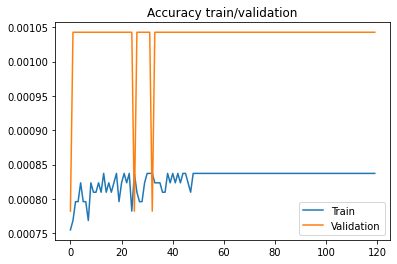

In [16]:
#Check model
from matplotlib import pyplot as plt
plt.title ('Accuracy train/validation')
plt.plot(fit_results.history['accuracy'],label="Train")
plt.plot(fit_results.history['val_accuracy'],label="Validation")
plt.legend()
plt.show()

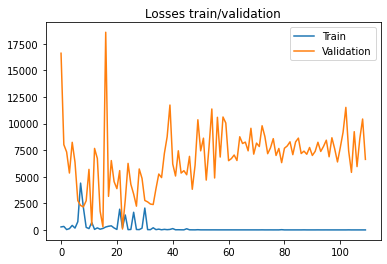

In [17]:
#Check model
plt.title ('Losses train/validation')
plt.plot(fit_results.history['loss'][10:],label="Train")
plt.plot(fit_results.history['val_loss'][10:],label="Validation")
plt.legend()
plt.show()

In [18]:
#Test model
import random
#Test model
test_sample=1000
random_indexes=[random.randint(0,len(input_data)) for x in range(test_sample)]
test_data = [input_data[x] for x in random_indexes]
output=[output_data[x] for x in random_indexes] 
predicted_test=model.predict(np.array(test_data)).tolist()

n=0
for i in range(1,test_sample):
    error=(output[i][0]/predicted_test[i][0])*100-100
    if error>5:
        n+=1
        print(f"reality:{output[i][0]}; forecast:{predicted_test[i][0]};error:{error}%")
print(f'{n} errors more than 5% in {test_sample} samples')

reality:0.11224489795918367; forecast:0.10472018271684647;error:7.185544416670211%
reality:0.11224489795918367; forecast:0.06515669822692871;error:72.26916190297962%
reality:0.5231292517006803; forecast:0.4637107849121094;error:12.813690930184634%
reality:0.2367278911564626; forecast:0.2243664711713791;error:5.50947738338381%
reality:0.2782312925170068; forecast:0.24116599559783936;error:15.369205275927996%
reality:0.24421768707482994; forecast:0.18238621950149536;error:33.901392189790755%
reality:0.5231292517006803; forecast:0.4505462646484375;error:16.109996408222244%
reality:0.8360544217687075; forecast:0.7423226833343506;error:12.626818570777672%
reality:0.14285714285714285; forecast:0.1346844881772995;error:6.0679999534057885%
reality:0.1554421768707483; forecast:0.13006971776485443;error:19.50681491580022%
reality:0.14625850340136054; forecast:0.09447672218084335;error:54.80903658088252%
reality:0.19727891156462585; forecast:0.15359541773796082;error:28.44062307977873%
reality:0.